In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import csv
import math
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import pytorch_lightning as pl
import glob

## First, we slice the train images into 31 x 31 pixels with the ground truth in the middle

In [51]:
def ndigit(n, x):
    x = str(x)
    while(len(x) < n):
        x = "0" + x
    return x

In [52]:
def load_data(res, files = 20):
    j = 0
    path = ["train", "02"]
    res = int((res-1)/2)
    
    for p in path:
        for f in range(files):
            image = np.load(f"images_{p}/images/image_{ndigit(3, f)}.npy")
            mask = np.load(f"masks_{p}/masks/mask_{ndigit(3, f)}.npy")
            image = np.reshape(image, (1024,1024,10))
            mask = np.reshape(mask, (1024,1024,1))
            ground_truths_pos = np.array(np.where(mask != 0)).T

            # Add padding to every image edge in case there are ground truths which are too close to an edge
            padded_image = np.pad(image, ((res, res), (res, res), (0,0)), mode='constant') 
            
            # Slice and save image
            for i in ground_truths_pos: 
                patch = (padded_image[i[0]-res : i[0]+res+1, i[1]-res : i[1]+res+1, :], np.array(mask[i[0], i[1], 0]))
                np.save(f"patches/train/patch_{ndigit(5, j)}.npy", np.array(patch, dtype="object"))                                 
                j += 1

In [46]:
# Check number of ground truths
pos = 0
for i in range(20):
    mask = np.load(f"masks_02/masks/mask_{ndigit(3, i)}.npy")
    ground_truths_pos = np.array(np.where(mask != 0)).T
    pos = pos + len(ground_truths_pos)
print(pos)

6624


In [53]:
res = 15
load_data(res)

## Then, we load the data and have a look

In [54]:
batch_size = 128

In [55]:
directory = 'patches/train'
file_paths = glob.glob(directory + '/*.npy')
trainset0 = [np.load(file_path, allow_pickle=True) for file_path in file_paths]
#delete every image that doesnt have the correct shape (!THIS MIGHT BE A REAL PROBLEM THAT NEEDS TO BE FIXED PROPERLY LATER!)
trainset = []
for pic in trainset0:
    if pic[0].shape == (res,res,10):
        trainset.append(pic)
print(len(trainset)) # Anzahl patches = 38862, d. h. es haben "nur" 668 fehlerhafte Dimensionen

38194


In [56]:
def enrich_channels(trainset, veggie, moisture):
# structure of the data: 
#trainset[pic_no][0][Horizontal][VERTIKAL][CHANNEL] -> Intensity 
#trainset[pic_no][1]-> Ground truth 
    print(f"Shape vorher: Liste mit ({res},{res},10) Bildern")
    counter = 0
    trainset = trainset

    if veggie:
        pic_no = 0
        for pic in trainset:
            counter += 1
            pixel_values = pic[:][:][0]
            channel8 = pixel_values[6]
            channel4 = pixel_values[2]
            channels = pic[0].shape[2]
            #print("Chanels:", channels)
            width = pic[0].shape[0]
            height = pic[0].shape[1]
            vegetation_array = np.divide((np.subtract(channel8, channel4)), np.add(channel8, channel4))
            trainset_transformed = np.append(trainset[pic_no][0], vegetation_array)
            trainset1_transformed = np.reshape(trainset_transformed, (width, height, channels + 1, ))
            trainset[pic_no] = (trainset1_transformed, trainset[pic_no][1])
            pic_no += 1

        print("Added Vegetation (B8-B4)/(B8+B4)")

    if moisture:
        pic_no = 0
        for pic in trainset:
            pixel_values = pic[:][:][0]
            channel8a = pixel_values[7]
            channel11 = pixel_values[8]
            channels = pic[0].shape[2]
            #print("Chanels:", channels)

            width = pic[0].shape[0]
            height = pic[0].shape[1]
            moisture_array = np.divide((np.subtract(channel8a, channel11)), np.add(channel8a, channel11))
            trainset_transformed = np.append(trainset[pic_no][0], moisture_array)
            trainset1_transformed = np.reshape(trainset_transformed, (width, height, channels + 1))
            #print(trainset1_transformed.shape)
            trainset[pic_no] = (trainset1_transformed, trainset[pic_no][1]) # append ground truth in tupel 
            pic_no += 1

        print("Added Moisture (B8A-B11)/(B8A+B11)")

    return trainset



In [57]:
trainset = enrich_channels(trainset, True, True)
#trainset[pic_no][0][h][w][channel] -> pixel value
#trainset[pic_no][1] -> Ground truth 

Shape vorher: Liste mit (15,15,10) Bildern


ValueError: cannot reshape array of size 2400 into shape (15,15,11)

In [28]:
X,y = trainset[0]
X.shape

(12, 31, 31)

In [40]:
class CustomDataset(Dataset):
    def __init__(self, trainset, transform):
        self.trainset = trainset
        self.transform = transform

    def __len__(self):
        return len(self.trainset)

    def __getitem__(self, index):
        data, target = self.trainset[index]

        if self.transform:
            data = self.transform(data)

        return data, target

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.ConvertImageDtype(torch.float),
     transforms.Lambda(lambda x : x / 3000),
     transforms.Lambda(lambda x : torch.where(x > 1, 1, x)), # clip images between 0 and 1
     transforms.Normalize(mean=(0.5,)*12,
                          std=(0.5,)*12)
     ])

In [41]:
# Create the custom dataset
custom_dataset = CustomDataset(trainset, transform=transform)

custom_dataset[0][0].shape

torch.Size([31, 12, 31])

In [23]:
# Calculate the sizes of the training set and validation set
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size

# Split trainset into trainset and valset
trainset, valset = random_split(trainset, [train_size, val_size])

# Create data loaders for the training set and validation set
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
validloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=0)


ValueError: axes don't match array

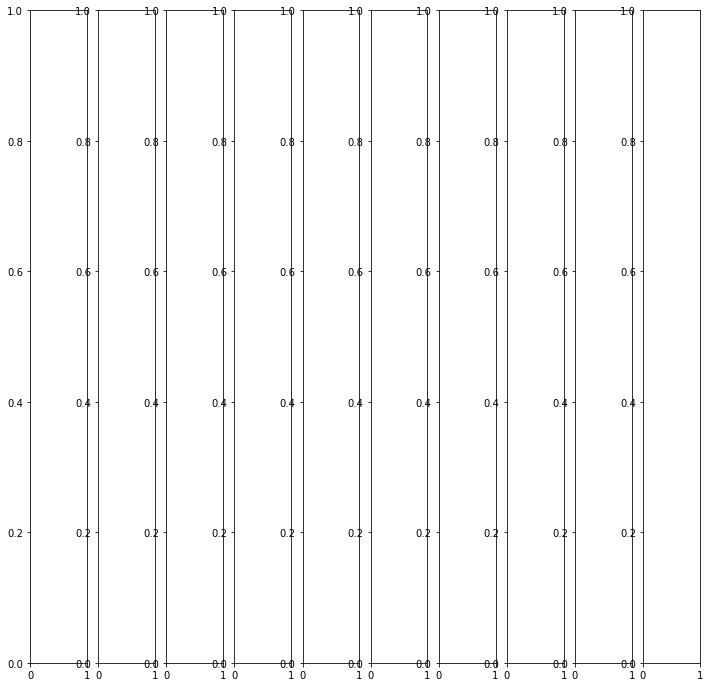

In [24]:
# f, axarr = plt.subplots(1,10, figsize=(12, 12))
# for i in range(10):
#     X,y = trainset[i]
#     X,y = X.transpose(0,-1).transpose(0,1) * 0.5 + 0.5, y
#     axarr[i].imshow(X)
#     axarr[i].axis('off')
#     axarr[i].set_title(f'{y}', fontsize='small')

## Next, we define the model and train it

In [28]:
class MyCNNModel(pl.LightningModule): # New! def init(self, layers, lr=0.01, classes=None): super().init() # <- Very important! self.lr = lr self.classes = classes ## Build model self.layers = nn.Sequential(layers) # Create a sequential model

    def __init__(self, *layers, classes=None):
        super().__init__()

        self.lr = 0.01  # Assign the learning rate here
        self.classes = classes

        self.layers = nn.Sequential(*layers)  # Create a sequential model
        
    def forward(self, X):
        return self.layers(X)

    def predict(self, X):
        with torch.no_grad():
            y_hat = self(X).argmax(1)
        if self.classes is not None:
            y_hat = [self.classes[i] for i in y_hat]
        return y_hat

    def training_step(self, batch, batch_idx, log_prefix='train'): # New !
        X, y = batch # Tuple with (X,y) in our case
        y_hat = self(X)
        loss = nn.MSELoss(y_hat, y)
        self.log(f"{log_prefix}_loss", loss.item(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx): # New!
        with torch.no_grad():
            return self.training_step(batch, batch_idx, log_prefix='valid')

    def configure_optimizers(self):
        # Adam with Weight Decay (Most commonly used)
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, weight_decay=0.01)

        # Simplest scheduler is ReduceLROnPlateau. This scheduler reduces the learning rate by 0.1
        # if the val_loss has not decreased within the last 10 epochs.
        scheduler = {
            # REQUIRED: The scheduler instance
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True),
            # The unit of the scheduler's step size, could also be 'step'.
            # 'epoch' updates the scheduler on epoch end whereas 'step'
            # updates it after a optimizer update.
            "interval": "epoch",
            # How many epochs/steps should pass between calls to
            # `scheduler.step()`. 1 corresponds to updating the learning
            # rate after every epoch/step.
            "frequency": 1,
            # Metric to to monitor for schedulers like `ReduceLROnPlateau`
            "monitor": "val_loss",
            # If set to `True`, will enforce that the value specified 'monitor'
            # is available when the scheduler is updated, thus stopping
            # training if not found. If set to `False`, it will only produce a warning
            "strict": True,
            # If using the `LearningRateMonitor` callback to monitor the
            # learning rate progress, this keyword can be used to specify
            # a custom logged name
            "name": None,
        }
        return {"optimizer": optimizer, 'lr-scheduler': scheduler}

## Implement model

In [90]:
# Implements entry to SepConv2d, see Lang et al. (2019), p. 6
class MyEntryLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.out_channels = out_channels

        self.proj_out = nn.Conv2d(in_channels, out_channels[len(out_channels)-1], (1,1))

        self.entry_blocks = nn.ModuleList()
        for i in range(len(out_channels)):
            self.entry_blocks.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels[i], (1, 1)),
                nn.BatchNorm2d(out_channels[i]),
                nn.ReLU()
            ))
            in_channels = out_channels[i]  # Update in_channels for next iteration

    def forward(self, x):
        x_entry = x
        for i in range(len(self.out_channels)):
            x_entry = self.entry_blocks[i](x_entry)
        x = self.proj_out(x)
        return (x + x_entry)

In [91]:
# Implements SepConv2D
class MySepConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, **kwargs):
        super().__init__()
        if in_channels == out_channels:
            self.proj_out = nn.Identity()
        else:
            self.proj_out = nn.Conv2d(in_channels, out_channels, (1,1), **kwargs)

        self.sep_conv_block = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_channels, in_channels, kernel, groups=in_channels, **kwargs), # depthwise SepConv
            nn.Conv2d(in_channels, out_channels, (1,1), **kwargs), # pointwise SepConv
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        x_sep_conv = self.sep_conv_block(x)
        x_sep_conv_2 = self.sep_conv_block(x_sep_conv) # performs second SepConv, see Lang et al. (2019), p. 6
        x = self.proj_out(x)
        return (x + x_sep_conv_2) # adds original input and sep_conv_2 output

In [92]:
tree_model = MyCNNModel(
    MyEntryLayer(12, [128, 256, 512]), # increase number of channels to 512
    MySepConvLayer(512, 512, (3,3), padding='same'),
    MySepConvLayer(512, 512, (3,3), padding='same'),
    MySepConvLayer(512, 512, (3,3), padding='same'),
    MySepConvLayer(512, 512, (3,3), padding='same'),
    MySepConvLayer(512, 512, (3,3), padding='same'),
    MySepConvLayer(512, 512, (3,3), padding='same'),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(512, 1)
)

In [93]:
# New, we need a trainer class
from pytorch_lightning.callbacks import RichProgressBar, RichModelSummary
trainer1 = pl.Trainer(devices=1, accelerator="cpu", precision='64', max_epochs=1,
                      callbacks=[RichProgressBar(refresh_rate=50),
                                 RichModelSummary(3),
                                ])

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [94]:
print(list(tree_model.parameters()))


[Parameter containing:
tensor([[[[ 0.0322]],

         [[-0.1153]],

         [[-0.0560]],

         ...,

         [[ 0.0128]],

         [[ 0.2286]],

         [[ 0.0630]]],


        [[[-0.2319]],

         [[ 0.1190]],

         [[ 0.2672]],

         ...,

         [[-0.0324]],

         [[-0.0277]],

         [[-0.0829]]],


        [[[-0.1140]],

         [[ 0.1899]],

         [[-0.2257]],

         ...,

         [[ 0.2231]],

         [[ 0.0564]],

         [[-0.2633]]],


        ...,


        [[[-0.2685]],

         [[ 0.2390]],

         [[ 0.2079]],

         ...,

         [[-0.1362]],

         [[ 0.0020]],

         [[-0.0088]]],


        [[[-0.1312]],

         [[ 0.2131]],

         [[-0.0141]],

         ...,

         [[ 0.0782]],

         [[-0.2338]],

         [[ 0.2205]]],


        [[[-0.1661]],

         [[ 0.0953]],

         [[-0.0077]],

         ...,

         [[-0.1244]],

         [[ 0.2518]],

         [[-0.1572]]]], requires_grad=True), Parameter co

In [95]:
trainer1.fit(tree_model, trainloader, validloader)

┏━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃    ┃ Name                    ┃ Type              ┃ Params ┃
┡━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0  │ layers                  │ Sequential        │  1.8 M │
│ 1  │ layers.0                │ MyEntryLayer      │  174 K │
│ 2  │ layers.0.proj_out       │ Conv2d            │  6.7 K │
│ 3  │ layers.0.entry_blocks   │ ModuleList        │  168 K │
│ 4  │ layers.1                │ MySepConvLayer    │  268 K │
│ 5  │ layers.1.proj_out       │ Identity          │      0 │
│ 6  │ layers.1.sep_conv_block │ Sequential        │  268 K │
│ 7  │ layers.2                │ MySepConvLayer    │  268 K │
│ 8  │ layers.2.proj_out       │ Identity          │      0 │
│ 9  │ layers.2.sep_conv_block │ Sequential        │  268 K │
│ 10 │ layers.3                │ MySepConvLayer    │  268 K │
│ 11 │ layers.3.proj_out       │ Identity          │      0 │
│ 12 │ layers.3.sep_conv_block │ Sequential        │  268 K │
│ 13 │ layers.4                │ MySepConvLayer    │  268 K │
│ 14 │ layers.4.proj_out       │ Identity          │      0 │
│ 15 │ layers.4.sep_conv_block │ Sequential        │  268 K │
│ 16 │ layers.5                │ MySepConvLayer    │  268 K │
│ 17 │ layers.5.proj_out       │ Identity          │      0 │
│ 18 │ layers.5.sep_conv_block │ Sequential        │  268 K │
│ 19 │ layers.6                │ MySepConvLayer    │  268 K │
│ 20 │ layers.6.proj_out       │ Identity          │      0 │
│ 21 │ layers.6.sep_conv_block │ Sequential        │  268 K │
│ 22 │ layers.7                │ AdaptiveMaxPool2d │      0 │
│ 23 │ layers.8                │ Flatten           │      0 │
│ 24 │ layers.9                │ Linear            │    513 │
└────┴─────────────────────────┴───────────────────┴────────┘

Trainable params: 1.8 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 1.8 M                                                                                                
Total estimated model params size (MB): 7

Output()

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

## Now, we can apply it

In [ ]:
f, axarr = plt.subplots(1,10, figsize=(12, 12))
for i in range(10):
    X,y = testset[i]
    y_hat = tree_model.predict(X.unsqueeze(0))[0]
    X,y = X.transpose(0,-1).transpose(0,1) * 0.5 + 0.5, testset.classes[y]
    axarr[i].imshow(X)
    axarr[i].axis('off')
    axarr[i].set_title(f'{y} - {y_hat}', fontsize='small')